# Overfitting
머신러닝을 하다 보면, 신경망이 training data에만 지나치게 적응되어, 그 외의 데이터에는 제대로 적응하지 못하는 상황이 발생합니다. [그림 1]에서 보이듯, Training data에 대해서는 정확도가 100%가 되지만, 앞으로 들어올 Test data에 대해서는 잘 맞추지 못하는 현상이 발생합니다. 이 현상을 과적합(Overfitting)이라고 부르죠. 머신러닝의 모델을 설계할 때에는, 훈련 데이터에는 포함되지 않는, 아직 보지 못한 데이터가 주어져도 바르게 선별할 수 있게 설계하는 것이 바람직합니다. 

[그림 1]

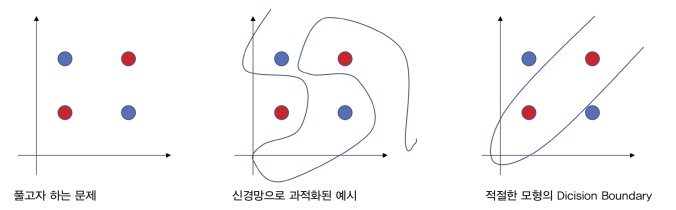

[출처] 이경택, 방성수, 안상준,『파이썬 딥러닝 파이토치』,정보문화사(2020)

그렇다면, 이런 Overfitting이 일어나는 경우는 무엇이 있을까요?

## 1) Training Data의 부족

모델을 설계할 때, 저희의 목적은 Training Data만으로 모집단의 해당하는 데이터들을 유추하는 것에 있습니다. 여기서, Training Data의 양이 많을수록 모집단의 특성을 반영할 확률이 높습니다. 또, Training Data가 모집단의 특성을 반영할수록, 과적합이 일어날 확률이 적어집니다.
이 경우 Training Data를 늘려주거나, 가지고 있는 Training Data가 적은 경우 K-Fold Cross Validation 기법을 활용할 수 있습니다.

## 2) 풀고자 하는 문제에 비해 복잡한 모델을 적용

풀고자 하는 문제가 간단한데에 반해, 너무 복잡한(너무 변수가 많거나, 모델 자체가 복잡한)모델을 사용할 때에도 Overfitting이 일어날 확률이 높습니다. 예를 들어, 특정 사람의 몸무게를 예측하는 모델을 설계한다면, '키'라는 변수만으로 단순 선형 회귀 모델을 이용해 어느 정도 정확도가 있는 모델을 만들 수 있을 것입니다. 하지만, '피부색', '지문', '머리카락 색' 등과 같은 변수도 추가해 모델을 설계한다면 어떤 현상이 발생할까요? 직관적으로 Overfitting이 발생할 확률이 높다는 것을 알 수 있습니다. 또, 모델이 너무 복잡할 경우 [그림 2]를 보시면 직관적으로 이해할 수 있습니다.

[그림 2]

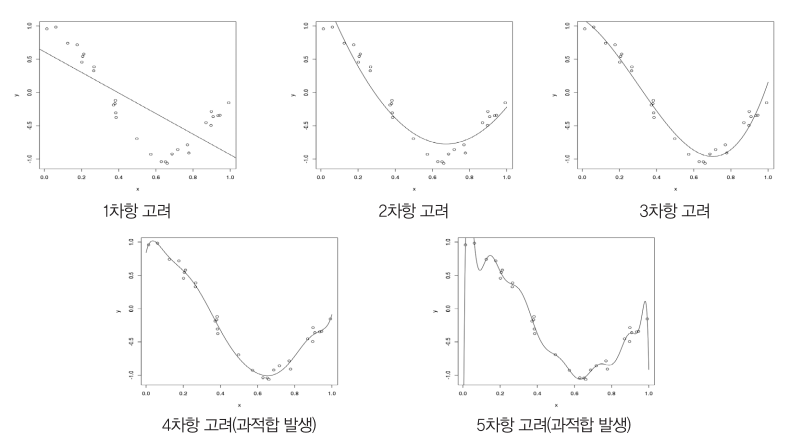

[출처] 이경택, 방성수, 안상준,『파이썬 딥러닝 파이토치』,정보문화사(2020)

## 3) 너무 많은 Epoch
Epoch가 너무 커져도 Overfitting이 발생할 확률이 높아집니다. [그림 3]과 같이 훈련 데이터에 너무 적응해버린다고 볼 수 있습니다.

[그림 3]

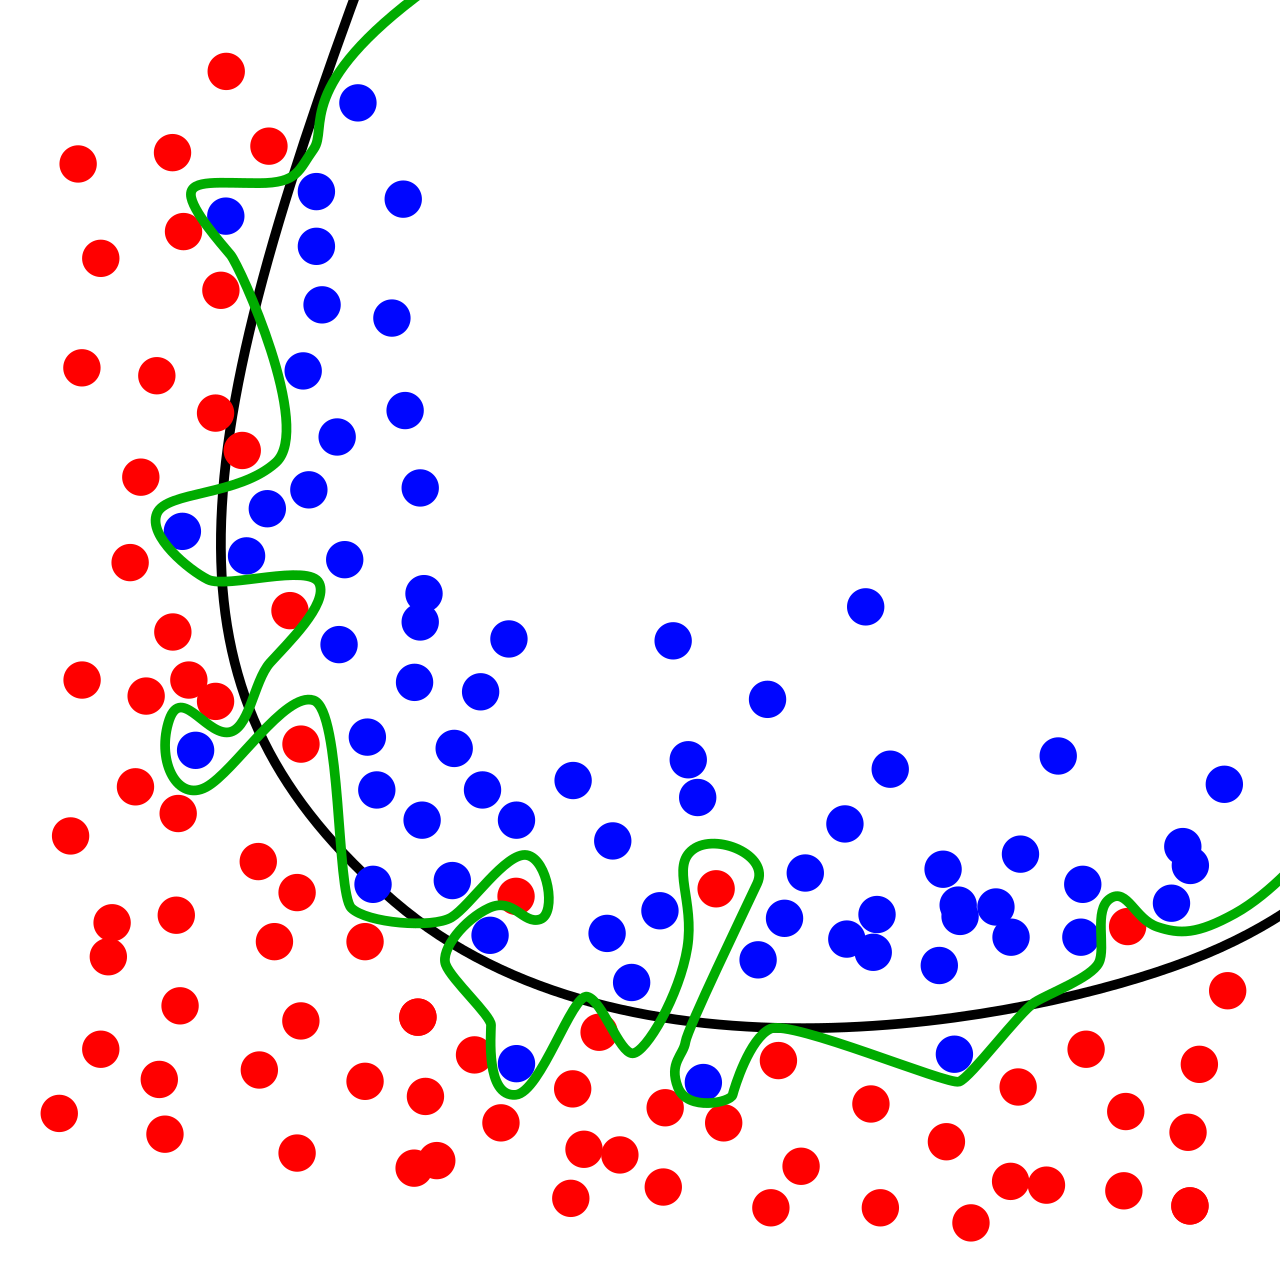

[출처] Wikipedia - Overfitting (https://en.wikipedia.org/wiki/Overfitting)

# Dropout
Overfitting 현상을 줄일 수 있게 모델을 설계하는 것이 바람직하다고 설명 드렸습니다. Overfitting을 억제하는 여러 테크닉 중에 Dropout에 대해 알아보겠습니다.

Dropout은, 뉴런을 임의로 삭제하면서 학습하는 방법입니다. Training중에 랜덤하게 은닉층의 노드를 Drop(삭제)하므로써 Generalization 효과를 기대할 수 있습니다. Drop된 노드는 [그림 4]과 같이 신호를 더이상 전달하지 않습니다. 매 Epoch마다 랜덤으로 Drop될 뉴런을 정하고, Test Data에 대해서는 모든 뉴련이 활성화됩니다.

[그림 4]

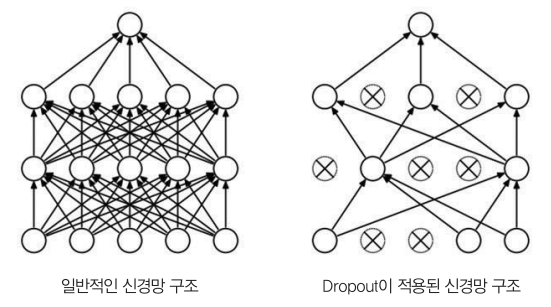

[출처] 이경택, 방성수, 안상준,『파이썬 딥러닝 파이토치』,정보문화사(2020)

# Early Stopping
Early Stopping은 너무 많은 Epoch때문에 Overfitting 현상이 발생할 경우 특정 시점에서 학습을 멈추는 것입니다. 일반적으로, hold-out validation set 에서의 성능이 더이상 증가하지 않을 때 학습을 중지시키게 됩니다.

# Dropout과 Early Stopping 실습

### Module import

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torchvision import transforms, datasets

### Device 설정

In [22]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version :', torch.__version__, ' Device :', DEVICE)

Using PyTorch version : 1.7.0+cu101  Device : cuda


### HyperParameter 설정

In [23]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


config = Config({
    'batch_size' : 32,
    'epochs': 100,
    'learning_rate': 0.01
})

### MNIST 데이터 다운로드

In [24]:
# MNIST 데이터 다운로드
train_dataset = datasets.MNIST(root="../data/MNIST",
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root="../data/MNIST",
                              train=False,
                              transform=transforms.ToTensor())


# 다운로드한 데이터를 Mini_Batch 단위로 분리해 저장
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=config.batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=config.batch_size,
                                          shuffle=False)

### loss function, optimizer 설정하기

In [27]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

### Training function 정의

In [28]:
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for batch_idx, (image, lable) in enumerate(train_loader):
        image = image.to(DEVICE)
        lable = lable.to(DEVICE)
        optimizer.zero_grad()
        out = model(image)
        loss = loss_function(out, lable)
        loss.backward()
        optimizer.step()

### Evaluate function 정의

In [29]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # 검증 과정 중에는 파라메터 값이 업데이트 되면 안되므로,
    # no_grad()를 이용하여, gradient의 흐름을 억제
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            out = model(image)
            test_loss += loss_function(out, label).item()
            prediction = out.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    return test_loss, test_accuracy

## 1. Dropout과 Early Stopping이 없는 모델

### Model 설계

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # 이미지 flatting
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

model = Net().to(DEVICE)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Train

In [ ]:
test_loss_arr_without = []
for Epoch in range(1, config.epochs+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print()
    print("[EPOCH: {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy))
    test_loss_arr_without.append(test_loss)

## 2. Dropout과 Early Stopping이 있는 모델

### Model 설계

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        # 0.5의 확률로 drop
        self.dropout_prob = 0.5

    def forward(self, x):
        # 이미지 flatting
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        # Dropout 적용
        x = nn.functional.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        # Dropout 적용
        x = nn.functional.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

model = Net().to(DEVICE)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Early Stopping Class

In [26]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train

In [ ]:
test_loss_arr = []
early_stopping = EarlyStopping(patience=5, verbose=True)
for Epoch in range(1, config.epochs+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print()
    print("[EPOCH: {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy))
    test_loss_arr.append(test_loss)
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        break

### Test loss 확인

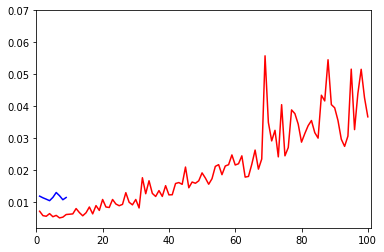

In [32]:
plt.plot(range(1, config.epochs+1), test_loss_arr_without, c='red')
plt.plot(range(1, len(test_loss_arr)+1), test_loss_arr, c='blue')
plt.axis([0, config.epochs+1, 0.002, 0.07])
plt.show()

# Result

Training 중, 아무것도 없는 모델의 경우(빨간색 그래프), Test Loss가 점점 증가하는 것을 확인할 수 있었습니다. 이는 너무 많은 Epoch에서 오는 Overfitting이 일어났다고 볼 수 있습니다. 그리고, Dropout과 Early stopping을 이용한 모델(파란색)은, 9번만에 학습을 중단했음을 알 수 있습니다. 이를 통해, Early stopping과 Dropout이 Overfitting을 어느정도 막을 수 있다는 것을 알 수 있었습니다.

### Reference
사이토 고키,『밑바닥부터 시작하는 딥러닝』, 개앞맵시 옮김, 한빛미디어(2019)

이경택, 방성수, 안상준,『파이썬 딥러닝 파이토치』,정보문화사(2020)

https://github.com/Bjarten/early-stopping-pytorch

https://wikidocs.net/61374